In [ ]:
import sys, os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(''))))

import pandas as pd
from lib.repo_interface import get_repo_interface
from lib import name_utils
import json
import matplotlib.pyplot as plt

plt.style.use('../style/style-formal.mplstyle')

class Dataset:
    def __init__(self, name, short_name, formal_name):
        self.name = name
        self.short_name = short_name
        self.formal_name = formal_name
    
    def get_FL_results(self):
        with open(f"../combined_fl_results/{self.short_name}_gpt3_results_R5_full.json", 'r') as f:
            fl_results = json.load(f) 
        return fl_results

    def get_valid_bugs(self):
        validity_data = f"../data/{self.name}_bug_validity.csv"

        bugs = pd.read_csv(validity_data)
        valid_bugs = bugs[bugs.validity == "ok"].bug.tolist()
        return valid_bugs

def called_in_test(ri):
    cit_info = {m: list() for m in ri._buggy_methods}
    short_names = {m: name_utils.get_method_name(m) for m in ri._buggy_methods}

    for test in ri.failing_test_signatures:
        snippet = ri.get_test_snippet(test)
        for m in cit_info:
            if "."+short_names[m]+"(" in snippet:
                cit_info[m].append(test)
    return cit_info

def exists_in_trace(ri):
    eit_info = {m: list() for m in ri._buggy_methods}
    short_names = {m: name_utils.get_method_name(m) for m in ri._buggy_methods}
    for test in ri.failing_test_signatures:
        fail_info = ri.get_fail_info(test)
        for m in eit_info:
            if "."+short_names[m]+"(" in fail_info:
                eit_info[m].append(test)
    return eit_info

DATASETS = [
    Dataset("bugsinpy", "bip", "BugsInPy"),
    Dataset("defects4j", "d4j", "Defects4J")
]

In [ ]:
meta_info_rows = []
method_info_rows = []
for dataset in DATASETS:
    valid_bugs = dataset.get_valid_bugs()
    for bug in valid_bugs:
        ri = get_repo_interface(bug)
        cit = called_in_test(ri)
        eit = exists_in_trace(ri)
        method_analysis = {}
        for method in cit:
            method_info_rows.append(
                [dataset.name, bug.split("_")[0], bug, method, len(cit[method]) > 0, len(eit[method]) > 0]
            )
        meta_info_rows.append(
            [dataset.name, bug.split("_")[0], bug, len(ri._fail_info), len(ri._buggy_methods)])

df = pd.DataFrame(data=meta_info_rows,
            columns=["dataset", "project", "bug_name", "num_failing_tests", "num_buggy_methods"])
method_info_df = pd.DataFrame(data=method_info_rows,
            columns=["dataset", "project", "bug_name", "method", "called_in_test", "exists_in_trace"])
method_info_df["(called in test, exists in trace)"] = method_info_df[['called_in_test', 'exists_in_trace']].apply(tuple, axis=1)

In [ ]:
df.groupby(["dataset", "project"]).agg({
    "bug_name": "count",
    "num_failing_tests": "mean",
    "num_buggy_methods": "mean"
}).reset_index().set_index(["dataset", "project"])

In [14]:
def get_call_patterns(dataset, bug, rep=5, model="gpt-3.5-turbo-0613", skip_error_run=True):
    result_paths = [
        f"../results/{dataset}_autofl_{r}/{model}/XFL-{bug}.json"
        for r in range(1, rep+1)
    ]
    call_patterns = []
    for rpath in result_paths:
        with open(rpath, 'r') as f:
            result = json.load(f)

            if skip_error_run and "openai.error.InvalidRequestError" in result["buggy_methods"]:
                continue
            
            call_patterns.append([])

            for m in result["messages"]:
                if m["role"] == "assistant" and "function_call" in m:
                     call_patterns[-1].append((m["function_call"]["name"], json.loads(m["function_call"]["arguments"])))
    return call_patterns

call_pattern_rows = []
for dataset in DATASETS:
    for bug in dataset.get_valid_bugs():
        call_patterns = get_call_patterns(dataset.short_name, bug, skip_error_run=True)
        if call_patterns:
            for s in call_patterns:
                call_pattern_rows.append([bug, len(s)])

call_pattern_df = pd.DataFrame(data=call_pattern_rows, columns=["bug_name", "call_seq_len"])

,called_in_test,exists_in_trace,call_seq_len
bug_name,,,
PySnooper_3,False,True,5.6
ansible_1,True,True,2.8
ansible_14,True,False,4.6
ansible_15,False,False,4.4
ansible_16,True,False,6.0
...,...,...,...
youtube-dl_5,False,False,5.2
youtube-dl_6,False,False,5.0
youtube-dl_7,False,False,5.2


(Called in Test, Exists in Trace)
(False, False)    5.131699
(False, True)     4.969858
(True, False)     5.070062
(True, True)      4.504938
Name: call_seq_len, dtype: float64
F_onewayResult(statistic=2.702415941039649, pvalue=0.0452486326444566)
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
    group1         group2      stat   pval  pval_corr reject
------------------------------------------------------------
(False, False) (False, True)  0.6835 0.4948       1.0  False
(False, False) (True, False)  0.2728 0.7852       1.0  False
(False, False)  (True, True)  2.8654 0.0045    0.0267   True
 (False, True) (True, False) -0.3262  0.745       1.0  False
 (False, True)  (True, True)  1.6785 0.0964    0.5785  False
 (True, False)  (True, True)  2.0297 0.0449    0.2693  False
------------------------------------------------------------
('(False, False)', '(True, True)', 2.8654, 0.0045, 0.0267, True)
3 0 9.5
9.5 6.6000000000000005


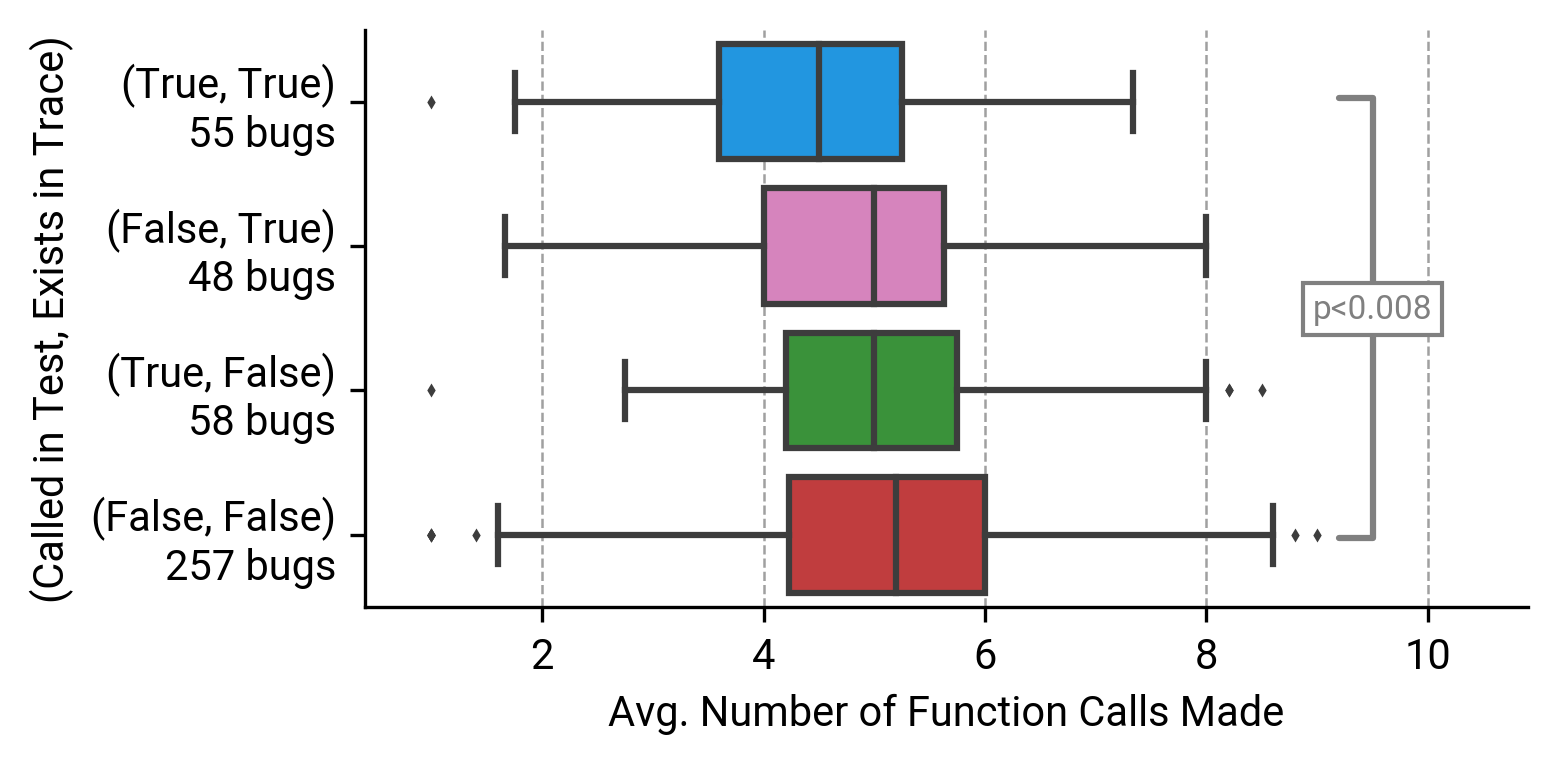

,called_in_test,exists_in_trace,call_seq_len
bug_name,,,
Chart_1,True,False,5.80
Chart_10,True,False,3.40
Chart_11,True,False,4.40
Chart_12,False,False,3.60
Chart_13,False,True,4.75
...,...,...,...
Time_5,True,True,5.00
Time_6,True,True,5.80
Time_7,True,True,4.00


In [15]:
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import MultiComparison

for dataset in DATASETS:
    anal_df = method_info_df[method_info_df.dataset == dataset.name].groupby("bug_name")[["called_in_test", "exists_in_trace"]].any().join(call_pattern_df.groupby("bug_name").call_seq_len.mean())
    display(anal_df)    
    # combination
    bug_type_col = "(Called in Test, Exists in Trace)"
    anal_df[bug_type_col] = anal_df[['called_in_test', 'exists_in_trace']].apply(tuple, axis=1).astype(str)

    fl_results = dataset.get_FL_results()
    anal_df = anal_df.join(pd.DataFrame(fl_results["confidence"], index=["confidence"]).T)

    bug_counts = anal_df.reset_index().groupby(bug_type_col).bug_name.count().to_dict()

    # plt.subplot(1, 2, 1)
    plt.figure(figsize=(5, 2.5))
    type_order = anal_df.groupby(bug_type_col).call_seq_len.median().sort_values().index.tolist()
    ax = sns.boxplot(data=anal_df, x="call_seq_len", y=bug_type_col,
                order=type_order, orient="h", fliersize=1)
    ax.set_yticklabels([f"{t}\n{bug_counts[t]} bugs" for t in type_order])
    ax.set_zorder(100)
    ax.set_axisbelow(True)

    print(anal_df.groupby(bug_type_col).call_seq_len.mean())
    plt.xlabel("Avg. Number of Function Calls Made")

    from scipy.stats import f_oneway

    print(f_oneway(*anal_df[~anal_df.call_seq_len.isna()].groupby(bug_type_col)["call_seq_len"].apply(list).tolist()))

    comp = MultiComparison(anal_df[~anal_df.call_seq_len.isna()]["call_seq_len"], anal_df[~anal_df.call_seq_len.isna()][bug_type_col])
    result = comp.allpairtest(ttest_ind, method='bonf')
    print(result[0])
    max_value = 8.2 if dataset.name == "defects4j" else 9.5
    annot_count = 0

    annot_color="grey"
    for ttest_result in reversed(result[2]):
        group1,group2,stat,pval,pval_corr,reject = ttest_result
        if pval < 0.008:
            print(ttest_result)
            y_pos = (type_order.index(group1) + type_order.index(group2))/2 + 0.05
            x_pos = max_value+annot_count*max_value*0.13
            print(type_order.index(group1),type_order.index(group2), x_pos)
            arrow_width = max([type_order.index(group1),type_order.index(group2)]) - min([type_order.index(group1),type_order.index(group2)])
            arrow_width = 2.2 * arrow_width

            print(max_value,arrow_width)
            plt.annotate(f'p<0.008', xy=(x_pos, y_pos),
                         xytext=(0, 0),
                         fontsize=8,
                         textcoords='offset pixels',
                         xycoords="data", va='bottom', ha="center",
                         bbox=dict(boxstyle='square', fc='white', color='grey'),
                         arrowprops=dict(
                             arrowstyle=f']-, widthA={arrow_width}, lengthA=1, angleA=90', lw=1.5, color=annot_color), color=annot_color)
            
            annot_count += 1

    plt.xlim((0.4, 10.9))

    plt.savefig(f"./figures/RQ1_call_pattern_hor_{dataset.name}.pdf", bbox_inches="tight")
    plt.show()
